In [1]:
import pystan
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
sns.set(rc={'figure.figsize':(14, 10)})

In [3]:
df = pd.read_csv('data/hierarchical_ode.csv', index_col=0)

In [4]:
df

,V1,V2,V3,V4,V5,time
1,4.809621,4.538929,5.529317,5.131033,5.231101,0.1
2,4.151672,5.825240,5.305460,5.381488,5.899066,0.2
3,5.644281,5.547855,6.180493,5.152891,5.078621,0.3
4,5.841844,6.552932,5.507744,5.406661,5.507618,0.4
5,5.005198,5.068168,6.298994,5.793250,4.752301,0.5
...,...,...,...,...,...,...
96,8.728886,7.736955,11.382547,12.745005,7.479495,9.6
97,8.002334,8.677325,11.882754,12.706334,7.452748,9.7
98,9.089271,8.085688,11.228556,12.079780,7.804624,9.8
99,8.686752,7.511824,11.035741,12.241480,6.517964,9.9


## 17.3.1

In [5]:
ocode = '''
functions {
    real[] bacteria_deriv(real t, real[] y, real[] theta, real[] x_r, int[] x_i) {
        real dy_dt[1];
        dy_dt[1] = theta[1]*y[1]*(1-theta[2]*y[1]);
        return dy_dt;
    }
}

transformed data {
    real x_r[0];
    int x_i[0];
}
'''
sm = pystan.StanModel(model_code=ocode)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e6aa0c57a15d6036a627c2d8ed74329f NOW.


## 17.3.2

In [6]:
df

,V1,V2,V3,V4,V5,time
1,4.809621,4.538929,5.529317,5.131033,5.231101,0.1
2,4.151672,5.825240,5.305460,5.381488,5.899066,0.2
3,5.644281,5.547855,6.180493,5.152891,5.078621,0.3
4,5.841844,6.552932,5.507744,5.406661,5.507618,0.4
5,5.005198,5.068168,6.298994,5.793250,4.752301,0.5
...,...,...,...,...,...,...
96,8.728886,7.736955,11.382547,12.745005,7.479495,9.6
97,8.002334,8.677325,11.882754,12.706334,7.452748,9.7
98,9.089271,8.085688,11.228556,12.079780,7.804624,9.8
99,8.686752,7.511824,11.035741,12.241480,6.517964,9.9


In [7]:
df.drop('time', axis=1).values.shape

(100, 5)

In [8]:
data = {
    'num_timesteps' : df.shape[0],
    'num_colonies': 5,
    'timesteps': df.time.values,
    'population': df.drop('time', axis=1).values
}

In [9]:
ocode = '''
functions {
    real[] bacteria_deriv(real t, real[] y, real[] theta, real[] x_r, int[] x_i) {
        real dy_dt[1];
        dy_dt[1] = theta[1]*y[1]*(1-theta[2]*y[1]);
        return dy_dt;
    }
}

data {
    int num_timesteps;
    int num_colonies;
    matrix[num_timesteps, num_colonies] population;
    real<lower=0> timesteps[num_timesteps];
}

transformed data {
    real x_r[0];
    int x_i[0];
}

parameters {
    real<lower=0> theta[2];
    real<lower=0> sigma;
    real<lower=0> y0[1];
}

model {
    real y_int[num_timesteps, 1];

    theta ~ normal(0,2);
    sigma ~ cauchy(0,5);
    y0 ~ normal(5,2);
    
    // there is one paramater set hence one estimated curve
    y_int = integrate_ode_rk45(bacteria_deriv, y0, 0, timesteps, theta, x_r, x_i);
    
    for(c_id in 1:num_colonies){
        for(t in 1:num_timesteps){
            population[t,c_id] ~ normal(y_int[t], sigma);
        }
    }
}

'''
sm = pystan.StanModel(model_code=ocode)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f7eb98415c313cd8620bda3c52af7cf4 NOW.


In [10]:
fit = sm.sampling(data=data, iter=1000, chains=4, seed=1)
fit

Inference for Stan model: anon_model_f7eb98415c313cd8620bda3c52af7cf4.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]   0.55  2.6e-3   0.07   0.42    0.5   0.55    0.6    0.7    763    1.0
theta[2]    0.1  5.5e-5 1.7e-3    0.1    0.1    0.1    0.1   0.11    950    1.0
sigma      1.67  1.5e-3   0.05   1.57   1.63   1.67    1.7   1.77   1222    1.0
y0[1]      5.01  8.8e-3   0.27    4.5   4.82    5.0   5.19   5.53    917    1.0
lp__     -505.5    0.06   1.41 -509.0 -506.2 -505.2 -504.4 -503.7    476   1.02

Samples were drawn using NUTS at Thu May 20 22:35:09 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

C:\Users\sendi\miniconda3\envs\bayes\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\sendi\miniconda3\envs\bayes\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

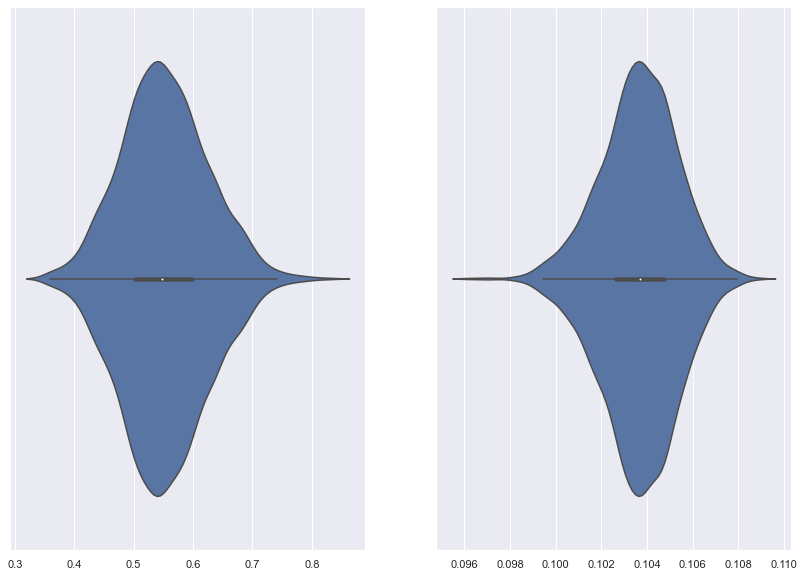

In [11]:
f, ax = plt.subplots(ncols=2)
sns.violinplot(fit.extract('theta')['theta'][:,0], bins=100, ax=ax[0])
sns.violinplot(fit.extract('theta')['theta'][:,1], bins=100, ax=ax[1])

## 17.3.3

<AxesSubplot:xlabel='time', ylabel='V'>

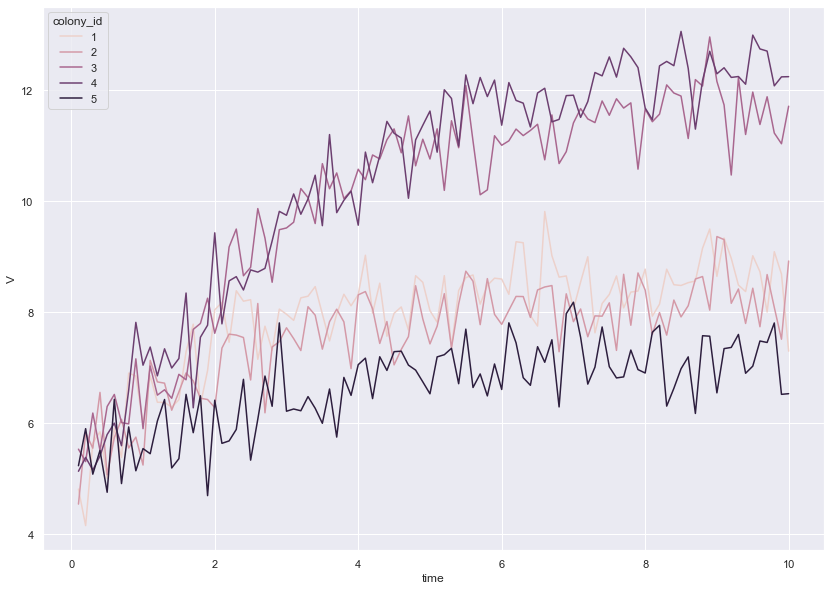

In [12]:
sns.lineplot(data=pd.wide_to_long(df, 'V', 'time', j='colony_id'), x='time', y='V', hue='colony_id')

Curves are kind of different, one theta for all seems not reasonable.

## 17.3.4

In [13]:
ocode = '''
functions {
    real[] bacteria_deriv(real t, real[] y, real[] theta, real[] x_r, int[] x_i) {
        real dy_dt[1];
        dy_dt[1] = theta[1]*y[1]*(1-theta[2]*y[1]);
        return dy_dt;
    }
}

data {
    int num_timesteps;
    int num_colonies;
    matrix[num_timesteps, num_colonies] population;
    real<lower=0> timesteps[num_timesteps];
}

transformed data {
    real x_r[0];
    int x_i[0];
}

parameters {
    real<lower=0> theta[num_colonies, 2];
    real<lower=0> sigma;
    real<lower=0> y0[1];
}

model {
    real y_int[num_timesteps, 1];

    sigma ~ cauchy(0,5);
    y0 ~ normal(5,2);
       
    for(c_id in 1:num_colonies){
        theta[c_id] ~ normal(0,2);
        y_int = integrate_ode_rk45(bacteria_deriv, y0, 0, timesteps, theta[c_id], x_r, x_i);
        for(t in 1:num_timesteps){
            population[t,c_id] ~ normal(y_int[t], sigma);
        }
    }
}

'''
sm = pystan.StanModel(model_code=ocode)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_40f881ca27a904ef10e66c15b0c9e219 NOW.


In [14]:
fit = sm.sampling(data=data, iter=1000, chains=4, seed=1)
fit

Inference for Stan model: anon_model_40f881ca27a904ef10e66c15b0c9e219.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1,1]   0.75  1.5e-3   0.06   0.63   0.71   0.75   0.79   0.88   1863    1.0
theta[2,1]   0.65  1.5e-3   0.06   0.54    0.6   0.64   0.68   0.78   1677    1.0
theta[3,1]   0.59  6.0e-4   0.02   0.54   0.57   0.59    0.6   0.63   1558    1.0
theta[4,1]   0.53  5.5e-4   0.02   0.49   0.51   0.53   0.54   0.57   1371    1.0
theta[5,1]   0.43  1.5e-3   0.06   0.32   0.39   0.43   0.47   0.57   1921    1.0
theta[1,2]   0.12  2.1e-5 1.0e-3   0.12   0.12   0.12   0.12   0.12   2378    1.0
theta[2,2]   0.12  2.6e-5 1.2e-3   0.12   0.12   0.12   0.12   0.12   2157    1.0
theta[3,2]   0.09  1.4e-5 6.4e-4   0.08   0.08   0.09   0.09   0.09   2008    1.0
theta[4,2]   0.08  1.6e-5 6.9e-4   0.08   0.08   0.08   0.08   0.08   1818 

In [15]:
alpha = fit.extract('theta')['theta'][:,:,0]
beta = fit.extract('theta')['theta'][:,:,1]

<AxesSubplot:xlabel='colony_id', ylabel='value'>

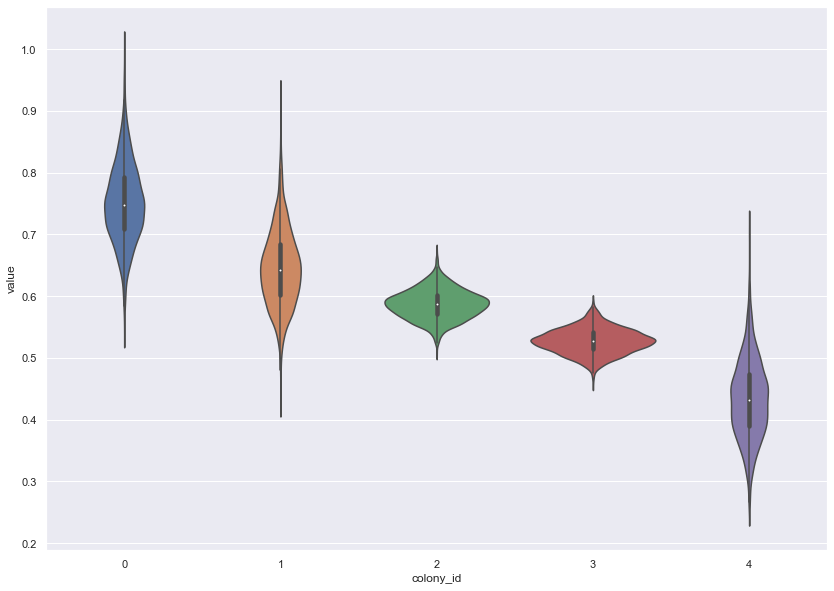

In [16]:
sns.violinplot(data=pd.DataFrame(alpha).melt(var_name='colony_id'), y='value', x='colony_id')

<AxesSubplot:xlabel='colony_id', ylabel='value'>

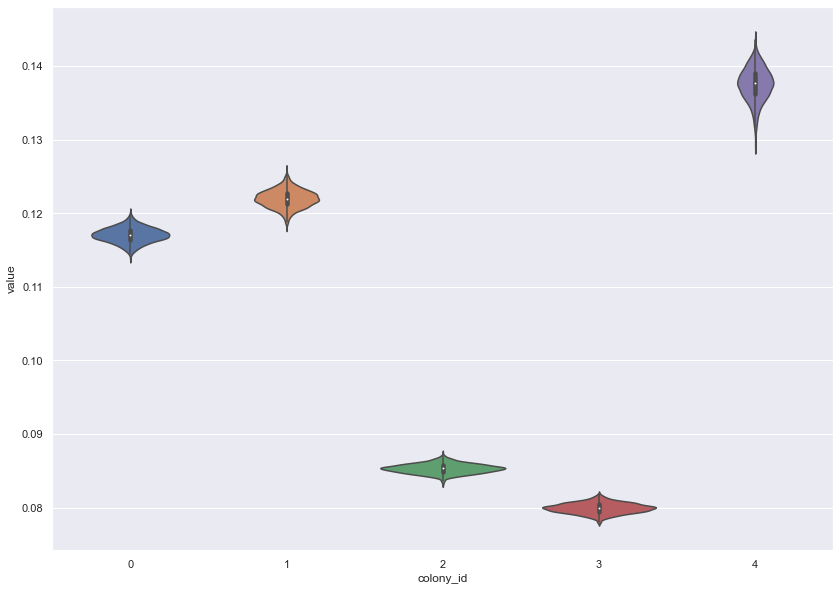

In [17]:
sns.violinplot(data=pd.DataFrame(beta).melt(var_name='colony_id'), y='value', x='colony_id')

## 17.3.5

In [18]:
ocode = '''
functions {
    real[] bacteria_deriv(real t, real[] y, real[] theta, real[] x_r, int[] x_i) {
        real dy_dt[1];
        dy_dt[1] = theta[1]*y[1]*(1-theta[2]*y[1]);
        return dy_dt;
    }
}

data {
    int num_timesteps;
    int num_colonies;
    matrix[num_timesteps, num_colonies] population;
    real<lower=0> timesteps[num_timesteps];
}

transformed data {
    real x_r[0];
    int x_i[0];
}

parameters {
    real a;
    real b;
    real c;
    real d;
    real<lower=0> theta[num_colonies, 2];
    real<lower=0> sigma;
    real<lower=0> y0[1];
}

model {
    real y_int[num_timesteps, 1];
    a ~ normal(20,5);
    b ~ normal(40,5);
    c ~ normal(10,3);
    d ~ normal(100,5);

    sigma ~ cauchy(0,5);
    y0 ~ normal(5,2);
       
    for(c_id in 1:num_colonies){
        theta[c_id,1] ~ gamma(a,b);
        theta[c_id,2] ~ gamma(c,d);
        y_int = integrate_ode_rk45(bacteria_deriv, y0, 0, timesteps, theta[c_id], x_r, x_i);
        for(t in 1:num_timesteps){
            population[t,c_id] ~ normal(y_int[t], sigma);
        }
    }
}

'''
sm = pystan.StanModel(model_code=ocode)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_976900812e30c3dfecb61fafb05d42b3 NOW.


In [19]:
fit = sm.sampling(data=data, iter=1000, chains=4, seed=1)
fit

Inference for Stan model: anon_model_976900812e30c3dfecb61fafb05d42b3.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a           22.66    0.06   2.92  17.17  20.68  22.76  24.59  28.61   2051    1.0
b           39.47    0.09    4.3  31.09  36.64  39.46  42.31  48.08   2130    1.0
c           10.96    0.03   1.41   8.16  10.02  10.94  11.88  13.92   2412    1.0
d          100.13     0.1   4.94  90.43  96.77 100.26 103.46 110.04   2695    1.0
theta[1,1]   0.72  1.2e-3   0.06   0.61   0.68   0.72   0.76   0.84   2286    1.0
theta[2,1]   0.63  1.3e-3   0.06   0.52   0.59   0.63   0.66   0.74   1996    1.0
theta[3,1]   0.58  5.8e-4   0.02   0.54   0.57   0.58    0.6   0.63   1781    1.0
theta[4,1]   0.53  5.2e-4   0.02   0.49   0.51   0.53   0.54   0.57   1542    1.0
theta[5,1]   0.45  1.3e-3   0.06   0.35   0.41   0.45   0.49   0.58   1941 

In [20]:
alpha = fit.extract('theta')['theta'][:,:,0]
beta = fit.extract('theta')['theta'][:,:,1]

<AxesSubplot:>

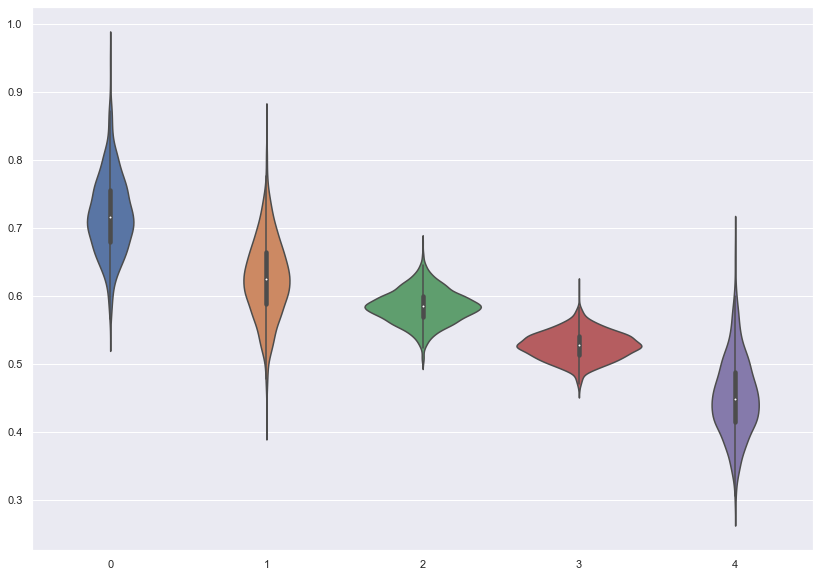

In [21]:
sns.violinplot(data=alpha)

<AxesSubplot:>

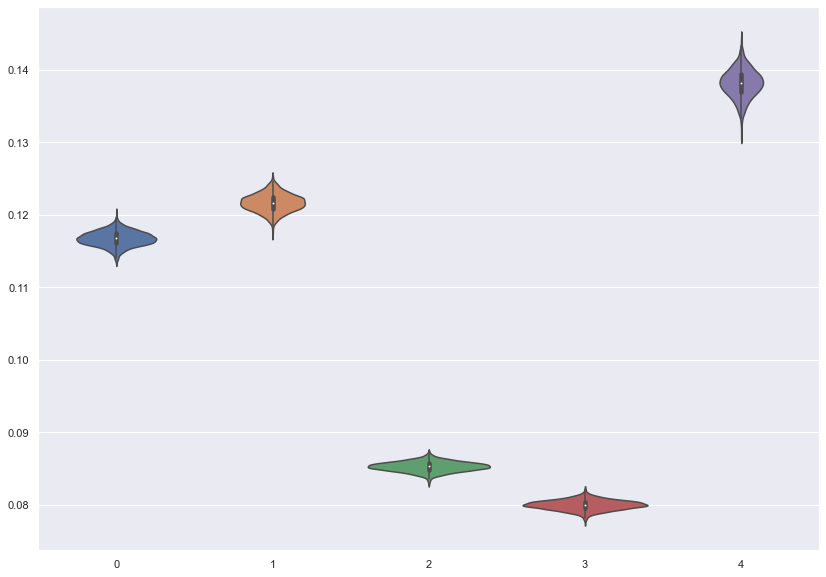

In [22]:
sns.violinplot(data=beta)

## 17.3.6

<AxesSubplot:ylabel='Count'>

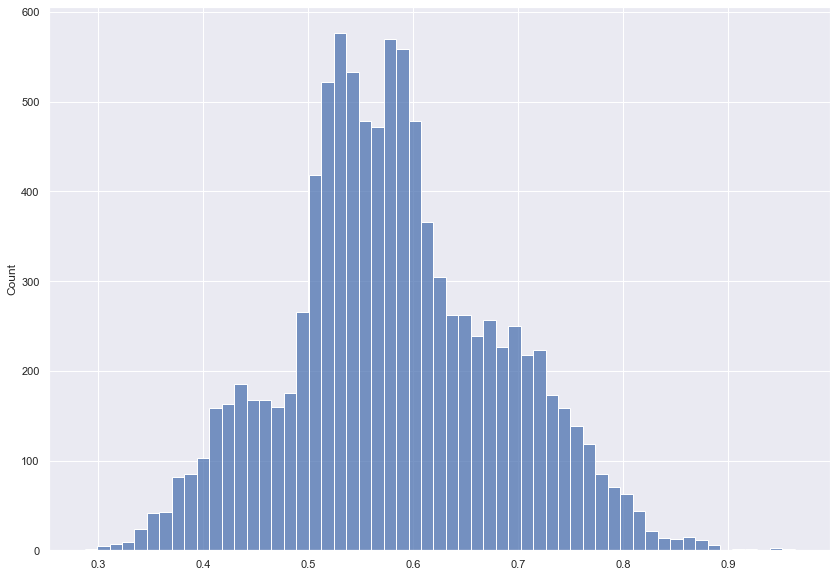

In [23]:
sns.histplot(alpha.reshape(-1))

<AxesSubplot:ylabel='Count'>

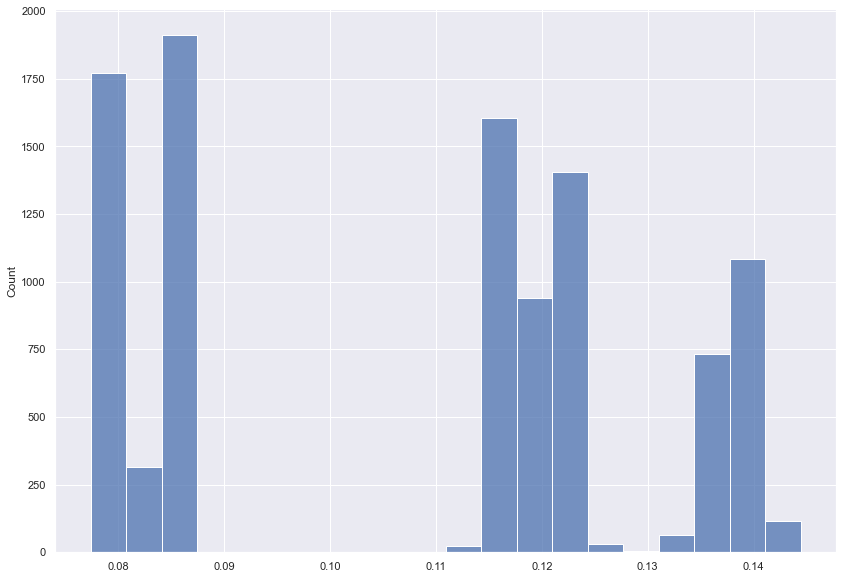

In [24]:
sns.histplot(beta.reshape(-1))